In [1]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import glob
import csv
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import matplotlib.patches as patch
from matplotlib import gridspec
from IPython.core.debugger import set_trace


In [2]:
trial_onsets = sp.io.loadmat('trialOnsets.mat')['trialOnsets']
lick_onsets = sp.io.loadmat('lickOnsets.mat')['lickOnsetTime'][0]

In [3]:
columns = list(sp.io.loadmat('trialOnsets.mat')['trialOnsets'].dtype.names)
columns.append(columns.pop(4))
columns

['supra',
 'thres',
 'sub',
 'mini',
 'whisker_supra',
 'whisker_thres',
 'whisker_sub',
 'whisker_mini',
 'whisker']

In [4]:
all_trial_onsets = [trial_onsets[type][0][0][0] for type in columns]
tr_onsets_sort = {col:trial_type for col, trial_type in zip(columns, all_trial_onsets)}

In [5]:
trial_length = np.median(np.diff(np.sort(np.concatenate(all_trial_onsets))))

In [6]:
log_df = pd.DataFrame(tr_onsets_sort).iloc[:,[0,1,3,2,5,6,8,7,4]]
log_df = log_df.melt(var_name = 'trial_type', value_name = 'trial_onset')
log_df['trial_onset'] = log_df['trial_onset'] - 0.05 #whisker stim was 0.05s before first laser onset
log_df['trial_offset'] = log_df['trial_onset']+trial_length
log_df.head()

,trial_type,trial_onset,trial_offset
0,mini,19.087200,26.227167
1,mini,69.047533,76.187500
2,mini,118.956600,126.096567
3,mini,168.966300,176.106267
4,mini,218.886133,226.026100


In [7]:
log_df['trial_type'].unique()

array(['mini', 'sub', 'thres', 'supra', 'whisker_mini', 'whisker_sub',
       'whisker_thres', 'whisker_supra', 'whisker'], dtype=object)

In [8]:
log_df['licks'] = log_df.apply(lambda x: [lick_onsets[(lick_onsets>= x['trial_onset']) & (lick_onsets <= x['trial_offset'])]], axis = 1)
log_df['licks'] = log_df['licks'].apply(lambda x: x[0])
log_df['licks'] = log_df.apply(lambda x: x['licks'] - x['trial_onset'] if len(x['licks'])>0 else [], axis = 1)
log_df.head()

,trial_type,trial_onset,trial_offset,licks
0,mini,19.087200,26.227167,[]
1,mini,69.047533,76.187500,[]
2,mini,118.956600,126.096567,[]
3,mini,168.966300,176.106267,[]
4,mini,218.886133,226.026100,[]


In [9]:
log_df['laser_int'] = 0
log_df.loc[log_df['trial_type'].str.contains('mini'), 'laser_int'] = 1
log_df.loc[log_df['trial_type'].str.contains('sub'), 'laser_int'] = 2
log_df.loc[log_df['trial_type'].str.contains('thres'), 'laser_int'] = 3
log_df.loc[log_df['trial_type'].str.contains('supra'), 'laser_int'] = 4

In [10]:
edges = np.arange(-0.25, 2.5, 0.01)
log_df['lick_counts'] = log_df['licks'].apply(lambda x: np.histogram(x, bins = edges)[0])

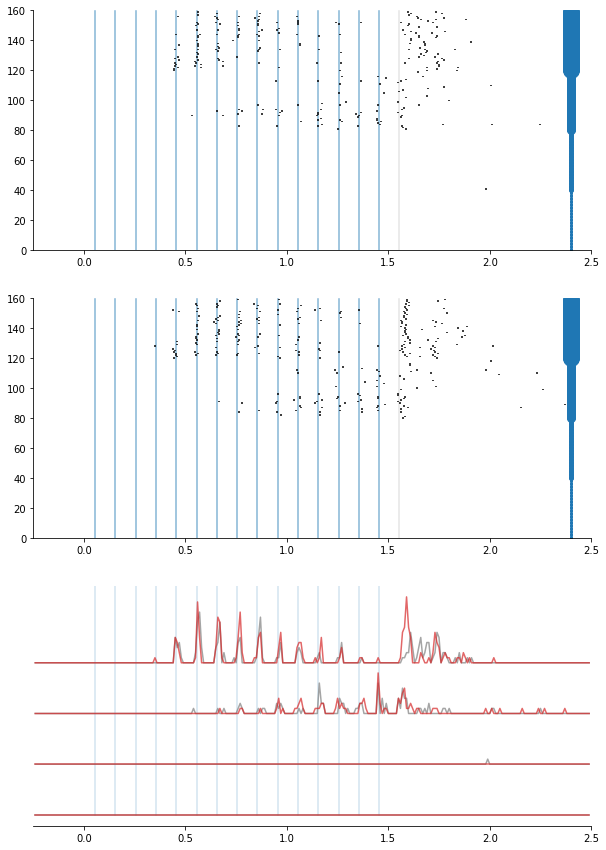

In [11]:
mpl.close('all')
fig = mpl.figure(figsize = (10, 15))

ax1 = fig.add_subplot(311)

no_whisker = log_df.loc[~log_df['trial_type'].str.contains('whisker'),:]
for trial,licks in enumerate(no_whisker['licks']):
    [mpl.vlines(lick, trial-0.5, trial+0.5) for lick in licks]
    ax1.scatter(2.4, trial, s = 4**(no_whisker.iloc[trial]['laser_int']), color = 'C0')


ax2 = fig.add_subplot(312)
laser_whisker = log_df.loc[log_df['trial_type'].str.contains('whisker_'),:]
for trial,licks in enumerate(laser_whisker['licks']):
    [mpl.vlines(lick, trial-0.5, trial+0.5) for lick in licks]
    ax2.scatter(2.4, trial, s = 4**(laser_whisker.iloc[trial]['laser_int']), color = 'C0')

for ax in [ax1,ax2]:
    ax.set_xlim(-0.25,2.5), ax.set_ylim(0,160)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, 160, color = 'C0', alpha = 0.3)) for i in range(int(1.5/.1))]
    ax.add_patch(patch.Rectangle([0.05+.1*15, 0], 0.005, 160, color = 'C7', alpha = 0.1))
    
### psths ###############################    
ax3 = fig.add_subplot(3,1,3)
# ax4 = fig.add_subplot(3,1,4)  
colors = iter(['C7', 'C3'])

for cond in [no_whisker, laser_whisker]:
    color = next(colors)
    for offset, t_type in enumerate(cond['trial_type'].unique()):
        l_counts = cond.loc[cond['trial_type'] == t_type, 'lick_counts']
        hist = np.mean((np.vstack(l_counts.as_matrix())), axis = 0)
        sd_hist = np.std((np.vstack(l_counts.as_matrix())), axis = 0)
        ax3.plot(edges[1:], hist+offset/4, color = color, alpha = 0.7)
#         ax4.plot(edges[1:], sd_hist+offset/2, color = color, alpha = 0.7)

[ax3.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, 160, color = 'C0', alpha = 0.1)) for i in range(int(1.5/.1))]
ax3.plot
for ax in [ax3]:
    ax.set_xlim(-0.25, 2.5)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_visible(False)


In [12]:
fig.savefig('EF118_licks.pdf', format='pdf', dpi=900, transparent = True)

In [ ]:
fig2 = mpl.figure(figsize = (10,3))

ax1 = fig2.add_subplot(211)

only_whisker = log_df.loc[log_df['trial_type']=='whisker',:]
for trial,licks in enumerate(only_whisker['licks']):
    [mpl.vlines(lick, trial-0.25, trial+0.5) for lick in licks]
    
ax1.set_xlim(0,only_whisker.shape[0])
ax1.set_ylim(0,only_whisker.shape[0])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig2

In [ ]:
clusters_f = sp.io.loadmat('clusteredSpikes.mat')
clusters = clusters_f['spikeTimes']
chan_num = clusters_f['numChans']

In [ ]:
clusters = np.array([np.concatenate(clust) for clust in clusters[0]])

In [ ]:
fig3 = mpl.figure(figsize = (20,7))
for offset, clust in enumerate(clusters):
    jitter = np.random.rand(clust.size)*.05
    mpl.scatter(clust, np.ones(clust.size)+jitter+offset,marker = '.', s = 1)


In [ ]:
clust_ff = []
for offset, clust in enumerate(clusters):
    hist = np.histogram(clust,bins = np.arange(0,3000,100))[0]
    clust_ff.append(np.std(hist)/np.mean(hist))

order = np.argsort(clust_ff)
clusters = clusters[order]
chan_num = chan_num[0][order]

In [ ]:
mpl.close('all')
fig4 = mpl.figure(figsize = (20,7))
for offset, clust in enumerate(clusters):
    jitter = np.random.rand(clust.size)*.05
    mpl.scatter(clust, np.ones(clust.size)+jitter+offset,marker = '.', s = 0.5)
    

In [ ]:
def sort_clust(clust): 
    return log_df.apply(lambda x: [clust[(clust>=x['trial_onset']-1) & 
                                          (clust<=x['trial_offset']-1)] - x['trial_onset']] ,axis = 1)
    
col_names = ['clust'+str(i) for i in range(len(clusters))]    
sorted_clusts = pd.DataFrame([sort_clust(clust) for clust in clusters], index = col_names).T
sorted_clusts = sorted_clusts.applymap(lambda x: x[0])
log_df = pd.concat([log_df, sorted_clusts], axis = 1)
log_df.head(3)

In [ ]:
id_vars = ['trial_type', 'trial_onset', 'trial_offset', 'licks', 'laser_int', 'lick_counts']
log_df = log_df.melt(id_vars = id_vars, var_name = 'cluster', value_name = 'spikes')
columns = list(log_df.columns)
columns = ['cluster'] + columns
columns.pop(7)
log_df = log_df[columns]
log_df.head()

In [ ]:
bin_size = 0.025

In [ ]:
count_xvals = np.arange(-1,3,bin_size)
log_df['count_xvals'] = [count_xvals]*log_df.shape[0]
log_df['spike_counts'] = log_df['spikes'].apply(lambda x: [np.histogram(x, bins = count_xvals)[0]])

In [ ]:
np.where([0,2,0])[0]

In [ ]:
laser_onsets = np.arange(0.05, 1.5, 0.1)
def first_spikes(laser_times, spike_times):
    pos_sp = [spike_times-laser for laser in laser_times]
    first_sp = [min(spikes[((spikes>0) & (spikes<0.1))]) 
                if len(spikes[((spikes>0) & (spikes<0.1))])>0 else np.nan for spikes in pos_sp]
    return np.array(first_sp)

In [ ]:
log_df['first_spikes'] = log_df['spikes'].apply(lambda x: first_spikes(laser_onsets,x))

In [ ]:
log_df['first_spikes_concat'] = log_df['first_spikes'].apply(lambda x: x[(~np.isnan(x))])

In [ ]:
log_df.head()

In [ ]:
def plot_rast(df,ax,window, laser = True):
    mpl.sca(ax)
    for trial in range(df.shape[0]):
        [mpl.vlines(lick, trial-0.5, trial+0.5, color = 'r') for lick in df.loc[trial, 'licks']]
        spikes = df.loc[trial, 'spikes']
        spikes = spikes[(spikes >= window[0]) & (spikes <= window[1])]
        [mpl.vlines(spike, trial-0.5, trial+0.5) for spike in spikes]
        if laser:
            ax.scatter(window[1]+window[1]*.06, trial, s = 4**(df.iloc[trial]['laser_int']), color = 'C0', clip_on=False)
    ax.set_xlabel('Time (s)'); ax.set_ylabel('Trial num')

In [ ]:
def prettify(ax, xlim, ylim, laser = True, axis_off = False, stim = False):
    ax.set_xlim(xlim), ax.set_ylim(ylim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if laser:
        [ax.add_patch(patch.Rectangle([0.05+.1*i, 0], 0.005, ylim[1], color = 'C0', alpha = 0.3)) for i in range(int(1.5/.1))]
        ax.add_patch(patch.Rectangle([0.05+.1*15, 0], 0.005, ylim[1], color = 'C7', alpha = 0.1))
        ax.text(xlim[1]*0.6, ylim[1]+10, 'Laser Stimulus', color = 'C0', alpha= 0.7)
        ax.text(xlim[1]*1.13, ylim[1]*2/3, 'Laser intensity', color = 'C0', rotation = 90)
    if axis_off:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.axis('off')
    if stim:
        ax.add_patch(patch.Rectangle([0,ylim[1]+10], 0.15, 15, color = 'C4', alpha = 0.5, clip_on = False))
        ax.text(0.175, ylim[1]+10, 'Whisker Stimulus', color = 'C4', alpha= 0.7)

In [ ]:
def calc_psth(df,bin_inds,bin_size):
    bin_inds = bin_inds[:-1]
    hist = np.vstack(df['spike_counts'].as_matrix())
    m_FR = np.mean(hist, axis = 0)/bin_size
    sem_FR = stats.sem(hist,axis = 0)/bin_size
    
    return m_FR[bin_inds], sem_FR[bin_inds]

In [ ]:
def compare_psths(clust_df, conds, ax, window, bin_size, colors = ['C7', 'C2'], offset = 0, laser = True):
    colors = iter(colors)
    clust_df = clust_df.reset_index(drop=True)
    bin_inds = (clust_df.loc[0, 'count_xvals'] >= window[0]) & (clust_df.loc[0, 'count_xvals'] <= window[1])
    bin_inds = bin_inds
    xvals = clust_df.loc[0, 'count_xvals'][bin_inds]+bin_size
    for cond in conds:
        color = next(colors)
        if laser == False: color = 'C4'
        cond_df = clust_df.loc[clust_df['trial_type'] == cond,:]
        mean, sem = calc_psth(cond_df, bin_inds, bin_size)
        ax.plot(xvals, mean+offset, color = color)
        ax.fill_between(xvals, mean+sem+offset, mean-sem+offset, alpha = 0.5,color = color)
        intensity = cond_df['laser_int'].iloc[0]
        if intensity > 0 :
            ax.scatter(xvals[-1]*1.06, offset, s = 4**intensity, color = 'C0', clip_on = False)


In [ ]:
def plot_spike_latency(clust_df, conds, ax, colors = ['C7', 'C2'], laser = True):
    for i, cond in enumerate(conds): 
        cond_df = clust_df.loc[clust_df['trial_type'] == cond, :]
        first_spikes = cond_df['first_spikes_concat']
        first_spikes = np.concatenate(first_spikes.as_matrix())
#         from IPython.core.debugger import Tracer; Tracer()() 
        if laser == False: color = 'C4'
        else: color = colors[i] 
        ax.hist(first_spikes, bins = np.arange(0,0.1,0.0025), color = color, alpha = 0.5)
        
    if laser:
        intensity = cond_df['laser_int'].iloc[0]
        ax.scatter(0.1*1.06, 50, s = 4**intensity, color = 'C0', clip_on = False)
        ax.add_patch(patch.Rectangle([0, 0], 0.005, 100, color = 'C0', alpha = 0.5))
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Freq of first spikes')
    ax.set_xlabel('Time from laser-stim onset (s)')
    ax.set_xlim([-0.005, 0.1]); ax.set_ylim(0,100)

In [ ]:
def plot_lick_hist(clust_df, conds, ax, colors)

In [ ]:
def plot_unit(ex_clust, windows = [[-0.25,2], [-0.1, 0.6]], bin_size = 0.025):

    mpl.close('all')
    fig = mpl.figure(figsize = (27, 25))
    gs = gridspec.GridSpec(8,2, height_ratios = [4,4,1,4,1,1,1,1])
    windows = iter(windows)

    for col in range(2):
        window = next(windows)
        ax1 = mpl.subplot(gs[0, col])
        no_whisker = ex_clust.loc[~ex_clust['trial_type'].str.contains('whisker'),:].reset_index(drop=True)
        plot_rast(no_whisker,ax1,window)

        ax2 = mpl.subplot(gs[1, col])
        laser_whisker = ex_clust.loc[ex_clust['trial_type'].str.contains('whisker_'),:].reset_index(drop=True)
        plot_rast(laser_whisker,ax2,window)

        ax3 = mpl.subplot(gs[2, col])
        only_whisker = ex_clust.loc[ex_clust['trial_type']=='whisker',:].reset_index(drop=True)
        plot_rast(only_whisker,ax3,window, laser = False)

        ax4 = mpl.subplot(gs[3, col])
        compare_psths(ex_clust, ['whisker'], ax4, window, bin_size, offset = -80, laser = False)
        compare_psths(ex_clust, ['mini', 'whisker_mini'], ax4, window, bin_size, offset = 0)
        compare_psths(ex_clust, ['sub', 'whisker_sub'], ax4, window, bin_size, offset = 80)
        compare_psths(ex_clust, ['thres', 'whisker_thres'], ax4, window, bin_size, offset = 160)
        compare_psths(ex_clust, ['supra', 'whisker_supra'], ax4, window, bin_size, offset = 240)
        ax4.text(0.8, 0.2, 'Laser-stim + whisker-stim', color = 'C2', transform = ax4.transAxes)
        ax4.text(0.8, 0.15, 'Laser-stim alone', color = 'C7', transform = ax4.transAxes)
        ax4.text(0.8, 0.1, 'Whisker-stim alone', color = 'C4', transform = ax4.transAxes)

        prettify(ax1, window, [0,160])
        prettify(ax2, window, [0,160], stim = True)
        prettify(ax3, window, [0,40], stim = True, laser = False)
        prettify(ax4, window, [-100,330], stim = True, axis_off = True)
    
    ax5 = mpl.subplot(gs[4, 0])
    plot_spike_latency(ex_clust,['supra', 'whisker_supra'], ax = ax5)
    ax6 = mpl.subplot(gs[5, 0])
    plot_spike_latency(ex_clust,['thres', 'whisker_thres'], ax = ax6)
    ax7 = mpl.subplot(gs[6, 0])
    plot_spike_latency(ex_clust,['sub', 'whisker_sub'], ax = ax7)
    ax8 = mpl.subplot(gs[7, 0])
    plot_spike_latency(ex_clust,['mini', 'whisker_mini'], ax = ax8)
   
   
    fig.subplots_adjust(hspace = 0.6, wspace = 0.3)
    return fig

In [ ]:
for clust in log_df['cluster'].unique():
    ex_clust = log_df[log_df['cluster'] == clust]
    fig = plot_unit(ex_clust)
    fig.savefig(str(clust)+'.pdf', format='pdf', dpi=900, transparent = True, orientation='landscape')

In [ ]:
ex_clust = log_df[log_df['cluster'] == 'clust3']
fig = plot_unit(ex_clust)
